In [86]:
import torch
from torch import nn
class SoftmaxWeight(nn.Module):
    def __init__(self, K, p, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        self.p = p
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)

    def log_prob(self, z):
        unormalized_log_w = self.f.forward(z)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

In [87]:
from IPython.display import clear_output

In [88]:
###MNIST###
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
fmnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)
fmnist_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=None)
randperm_train = torch.randperm(fmnist_trainset.targets.shape[0])
randperm_test_val = torch.randperm(fmnist_testset.targets.shape[0])

num_train = 1000

train_labels = fmnist_trainset.targets[randperm_train][:num_train]
test_labels = fmnist_testset.targets[randperm_test_val][:5000]
validation_labels = fmnist_testset.targets[randperm_test_val][5000:]

extracted_train = fmnist_trainset.data.flatten(start_dim=1).float()[randperm_train][:num_train]
train_samples = (extracted_train + torch.rand(extracted_train.shape))/256
extracted_test = fmnist_testset.data.flatten(start_dim=1).float()[randperm_test_val][:5000]
test_samples = (extracted_test + torch.rand(extracted_test.shape))/256
extracted_validation = fmnist_testset.data.flatten(start_dim=1).float()[randperm_test_val][5000:]
validation_samples = (extracted_validation + torch.rand(extracted_validation.shape))/256

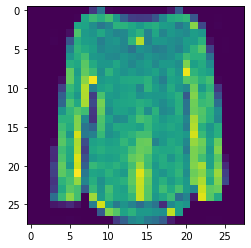

In [89]:
plt.imshow(train_samples[0].reshape(28,28))
plt.show()

In [90]:
from tqdm import tqdm

In [91]:
w = SoftmaxWeight(10,784,[32,32,32])
optim = torch.optim.Adam(w.parameters(), lr = 5e-4)
list_accuracy = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_samples = train_samples.to(device)
train_labels = train_labels.to(device)

test_samples = test_samples.to(device)
test_labels = test_labels.to(device)

validation_samples = validation_samples.to(device)
validation_labels = validation_labels.to(device)

counts = torch.unique(train_labels, return_counts = True)[1]/train_labels.shape[0]
list_accuracy_train = []
list_accuracy_test = []
list_accuracy_validation = []

w.to(device)
pbar = tqdm(range(1000))
for t in pbar:
    optim.zero_grad()
    loss_train = -torch.sum((w.log_prob(train_samples)*counts)[range(train_samples.shape[0]),train_labels])
    with torch.no_grad():
        accuracy_train = torch.mean((torch.max(w.log_prob(train_samples), dim = 1)[1] == train_labels).float())
        list_accuracy_train.append(accuracy_train.cpu().item())
        accuracy_test = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
        list_accuracy_test.append(accuracy_test.cpu().item())
        accuracy_validation= torch.mean((torch.max(w.log_prob(validation_samples), dim = 1)[1] == validation_labels).float())
        list_accuracy_validation.append(accuracy_validation.cpu().item())
    loss_train.backward()
    optim.step()
    pbar.set_postfix_str('loss_train = ' + str(round(loss_train.item(),4)) +'; acc_train =' + str(round(accuracy_train.item(),4)) + '; acc_test =' + str(round(accuracy_test.item(),4)) + '; acc_validation =' + str(round(accuracy_validation.item(),4)))
w.cpu()
accuracy = torch.mean((torch.max(w.log_prob(validation_samples), dim = 1)[1] == validation_labels).float())

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.68it/s, loss_train = 1.0964; acc_train =1.0; acc_test =0.783; acc_validation =0.7822]


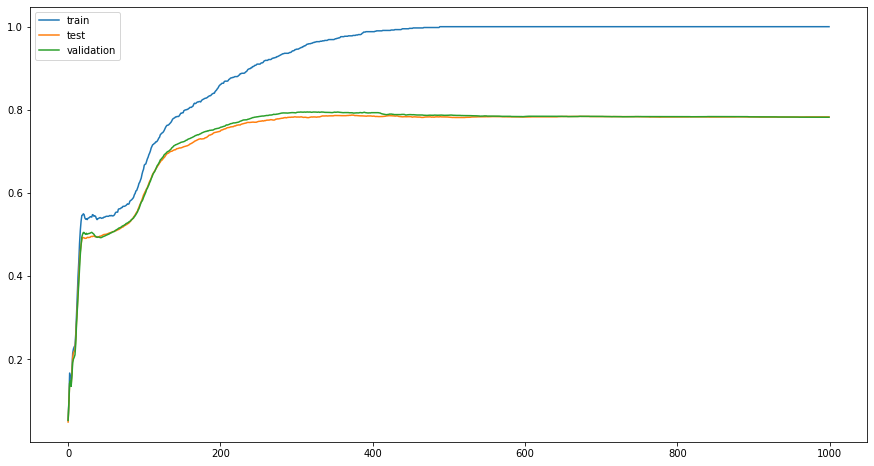

In [92]:
plt.figure(figsize = (15,8))
plt.plot(list_accuracy_train, label = 'train')
plt.plot(list_accuracy_test, label = 'test')
plt.plot(list_accuracy_validation, label = 'validation')
plt.legend()
plt.show()

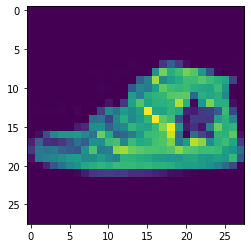

tensor([1.8216e-03, 4.0005e-03, 2.0444e-03, 2.7716e-03, 2.9116e-04, 4.9191e-02,
        2.6796e-05, 9.2491e-01, 5.6974e-03, 9.2495e-03],
       grad_fn=<ExpBackward0>)


In [93]:
plt.imshow(test_samples[0].reshape(28,28))
plt.show()
print(torch.exp(w.log_prob(test_samples[0])))

 90%|██████████████████████████████████████████▎    | 9/10 [04:52<00:28, 28.40s/it, loss_train = 40.7216; acc_current =0.9922; acc_train =0.999; acc_test =0.7244; acc_validation =0.7402]

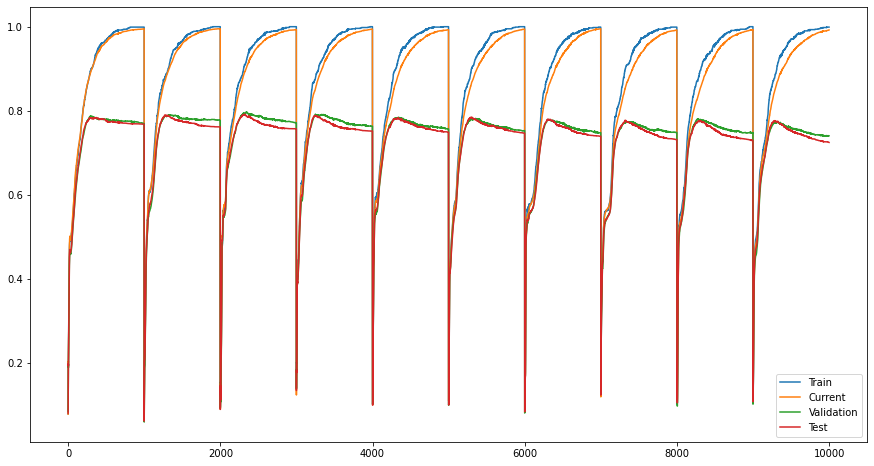

100%|██████████████████████████████████████████████| 10/10 [04:52<00:00, 29.27s/it, loss_train = 40.7216; acc_current =0.9922; acc_train =0.999; acc_test =0.7244; acc_validation =0.7402]


In [94]:
list_accuracy_current_gibbs = []
list_accuracy_train_gibbs = []
list_accuracy_test_gibbs = []
list_accuracy_validation_gibbs = []
pbar = tqdm(range(10))
for i in pbar:
    fake_labels= torch.distributions.Categorical(torch.exp(w.to(device).log_prob(test_samples.to(device)))).sample()
    current_samples = torch.cat([train_samples.to(device), test_samples.to(device)], dim = 0)
    w = SoftmaxWeight(10,784,[32,32,32]).to(device)
    optim = torch.optim.Adam(w.parameters(), lr = 5e-4)
    for t in range(1000):
        current_labels = torch.cat([train_labels.to(device), fake_labels], dim =0)
        optim.zero_grad()
        counts = torch.unique(current_labels, return_counts = True)[1]/current_labels.shape[0]
        loss_train = -torch.sum((w.log_prob(current_samples)*counts)[range(current_labels.shape[0]),current_labels])
        with torch.no_grad():
            accuracy_current = torch.mean((torch.max(w.log_prob(current_samples), dim = 1)[1] == current_labels).float())
            accuracy_validation = torch.mean((torch.max(w.log_prob(validation_samples), dim = 1)[1] == validation_labels).float())
            accuracy_train = torch.mean((torch.max(w.log_prob(train_samples), dim = 1)[1] == train_labels).float())
            accuracy_test = torch.mean((torch.max(w.log_prob(test_samples), dim = 1)[1] == test_labels).float())
            list_accuracy_current_gibbs.append(accuracy_current.cpu().item())
            list_accuracy_train_gibbs.append(accuracy_train.cpu().item())
            list_accuracy_test_gibbs.append(accuracy_test.cpu().item())
            list_accuracy_validation_gibbs.append(accuracy_validation.cpu().item())
        
        loss_train.backward()
        optim.step()
    clear_output(wait = True)
    pbar.set_postfix_str('loss_train = ' + str(round(loss_train.item(),4))+'; acc_current =' + str(round(accuracy_current.item(),4)) +'; acc_train =' + str(round(accuracy_train.item(),4)) + '; acc_test =' + str(round(accuracy_test.item(),4)) + '; acc_validation =' + str(round(accuracy_validation.item(),4)))
    plt.figure(figsize = (15,8))
    plt.plot(list_accuracy_train_gibbs, label = 'Train')
    plt.plot(list_accuracy_current_gibbs, label ='Current')
    plt.plot(list_accuracy_validation_gibbs, label = 'Validation')
    plt.plot(list_accuracy_test_gibbs, label = 'Test')
    plt.legend()
    plt.show()